In [1]:
import os
import glob
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gatspy import periodic

import warnings
warnings.filterwarnings('ignore')

# Preparing Dataset From Saha et al. (2017)

In [2]:
saha = pd.read_csv('392work2.tab', sep = '\s{5}', header = None, 
                   names = ['HJD-2400000.0', 'Magnitude', 'Uncertainty in Magnitude', 'Passband'], engine = 'python')
saha.info()
saha.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 4 columns):
HJD-2400000.0               370 non-null float64
Magnitude                   370 non-null float64
Uncertainty in Magnitude    370 non-null float64
Passband                    370 non-null float64
dtypes: float64(4)
memory usage: 11.6 KB


,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,56423.664062,27.769,0.030,0.0
1,56423.812500,28.160,0.029,0.0
2,56423.894531,28.089,0.021,0.0
3,56424.718750,27.882,0.024,0.0
4,56424.808594,28.105,0.029,0.0


In [3]:
saha['Passband'] = saha['Passband'].replace({0.0 : 'u', 1.0 : 'g', 2.0 : 'r', 3.0 : 'i', 4.0: 'z'})
saha.head()

,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,56423.664062,27.769,0.030,u
1,56423.812500,28.160,0.029,u
2,56423.894531,28.089,0.021,u
3,56424.718750,27.882,0.024,u
4,56424.808594,28.105,0.029,u


In [4]:
saha.tail()

,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
365,57116.839844,21.776,0.015,z
366,57116.851562,21.850,0.017,z
367,57116.863281,21.840,0.019,z
368,57116.890625,21.875,0.012,z
369,57116.906250,21.879,0.012,z


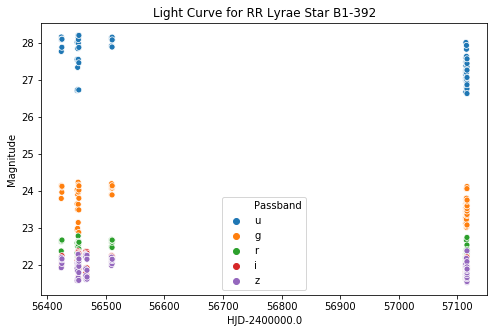

In [5]:
plt.figure(figsize = (8, 5))
plt.title('Light Curve for RR Lyrae Star B1-392')
sns.scatterplot(x = 'HJD-2400000.0', y = 'Magnitude', data = saha, hue = 'Passband');

# Computing the Hybrid Statistic

In [6]:
def phase_dispersion_minimization(times, magnitudes, uncertainties, periods):
    """Implements the formula for calculating the Lafler-Kinman statistic
    using weighted phase dispersion minimization."""
    
    lafler_kinmans = []
    for period in periods:
        
        folded = (times / period) % 1
        ordered = sorted(list(zip(folded, magnitudes, uncertainties)), key = lambda x: x[0])
        unzipped = [list(t) for t in zip(*ordered)]
        measurements, errors = unzipped[1], unzipped[2]
        wrap_measurements = [measurements[-1]] + measurements
        wrap_errors = [errors[-1]] + errors
        
        weights = []
        for i in range(1, len(wrap_errors)):
            weights.append(1 / (wrap_errors[i]**2 + wrap_errors[i - 1]**2))
        
        numerator = []
        for j in range(1, len(wrap_measurements)):
            difference = (wrap_measurements[j] - wrap_measurements[j - 1])**2
            numerator.append(difference * weights[j - 1])
        
        weighted_mean = np.mean(np.array(measurements) * np.array(weights))
        denominator = sum(weights)*sum((np.array(measurements) - weighted_mean)**2)
        lafler_kinman = sum(numerator) / denominator
        lafler_kinmans.append(lafler_kinman)

    return np.array(lafler_kinmans)


def lomb_scargle_analysis(times, magnitudes, uncertainties, min_period = 0.2, max_period = 1.5):
    """Generates the Lomb-Scargle periodogram for a variable star light curve."""
    fit_periods = np.linspace(min_period, max_period, 10000)
    model = periodic.LombScargleFast(fit_period = True)
    model.optimizer.period_range = (min_period, max_period)
    model.fit(times, magnitudes, uncertainties)
    return [fit_periods, model.score(fit_periods)]


def hybrid_statistic(times, magnitudes, uncertainties):
    """Computes the hybrid statistic defined by Saha et al. (2017).
    Then, uses the hybrid statistic to find the best period."""
    periods, pi = lomb_scargle_analysis(times, magnitudes, uncertainties)
    theta = phase_dispersion_minimization(times, magnitudes, uncertainties, periods)
    hybrid_statistic = np.array(2 * pi / theta)
    best_period = periods[np.argmax(hybrid_statistic)]
    return [1 / periods, pi, 2 / theta, hybrid_statistic, best_period]

In [7]:
def filter_data(passband = 'g', sparsity = 1.0, seed = 0):
    """Returns light curve data in a specific band."""
    
    filtered = saha[saha['Passband'] == passband]
    
    if sparsity != 1.0:
        if seed == 0:
            filtered = filtered.sample(frac = sparsity)
        else:
            filtered = filtered.sample(frac = sparsity, random_state = seed)
        
    epoch = filtered.iloc[:, 0].values
    magnitudes = filtered.iloc[:, 1].values
    magnitude_errors = filtered.iloc[:, 2].values
    return epoch, magnitudes, magnitude_errors


def plot_periodogram(passband = 'g', sparsity = 1.0, seed = 0, plot = True):
    """Plots Lomb-Scargle, Lafler-Kinman, and hybrid periodograms for a variable star light curve."""
    
    epoch, magnitudes, magnitude_errors = filter_data(passband = passband, sparsity = sparsity, seed = seed)
    frequencies, ls_powers, lk_powers, hybrid_powers, best_period = hybrid_statistic(epoch, magnitudes, magnitude_errors)
    
    if plot:
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($\Pi$)')
        plt.title(f'Lomb-Scargle Periodogram for {passband} Passband')
        plt.plot(frequencies, ls_powers, label = f"Sparsity of {sparsity}")
        plt.legend();
    
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2$ / $\Theta$)')
        plt.title(f'Lafler-Kinman Periodogram for {passband} Passband')
        plt.plot(frequencies, lk_powers, label = f"Sparsity of {sparsity}")
        plt.legend();
    
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
        plt.title(f'Hybrid Periodogram for {passband} Passband')
        plt.plot(frequencies, hybrid_powers, label = f"Sparsity of {sparsity}")
        plt.legend();
    
    return [frequencies, ls_powers, lk_powers, hybrid_powers, best_period]

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period in g Passband is 0.5016301630163016
True Period is 0.501624 Days


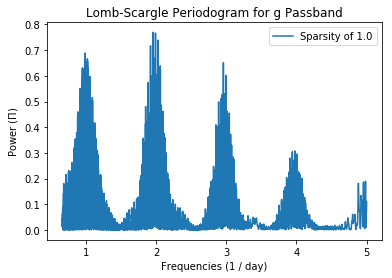

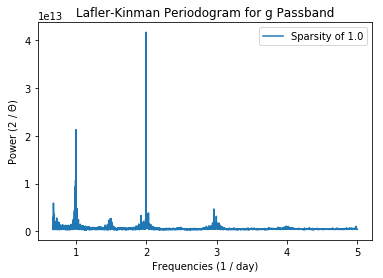

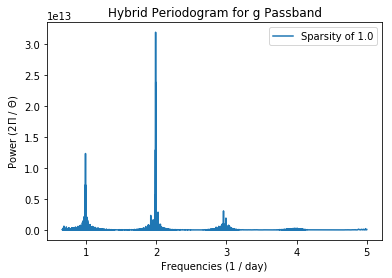

In [8]:
true_period = 0.5016240
g_period = plot_periodogram()[4];

print("\nBest Period in g Passband is", g_period)
print("True Period is", true_period, "Days")

In [9]:
def find_best_period(sparsity = 1.0, seed = 0, plot = True):
    """Find the best period by averaging across the results from each passband."""
    
    freqs, ls_powers, lk_powers, hybrid_powers, period = plot_periodogram(passband = 'g', sparsity = sparsity, 
                                                                          seed = seed, plot = False)
    print('\n')
    
    for passband in ['u', 'r', 'i', 'z']:
        new_results = plot_periodogram(passband = passband, sparsity = sparsity, seed = seed, plot = False)
        ls_powers = ls_powers + new_results[1]
        lk_powers = lk_powers + new_results[2]
        hybrid_powers = hybrid_powers + new_results[3]
        print('\n')
        
    if plot:
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($\Pi$)')
        plt.title('Lomb-Scargle Periodogram for All Passbands')
        plt.plot(freqs, ls_powers, label = f'Sparsity of {sparsity}')
        plt.legend();
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2$ / $\Theta$)')
        plt.title('Lafler-Kinman Periodogram for All Passbands')
        plt.plot(freqs, lk_powers, label = f'Sparsity of {sparsity}')
        plt.legend();
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
        plt.title('Hybrid Periodogram for All Passbands')
        plt.plot(freqs, hybrid_powers, label = f'Sparsity of {sparsity}')
        plt.legend();
        
    best_ls_period = 1 / (freqs[np.argmax(ls_powers)])
    best_lk_period = 1 / (freqs[np.argmax(lk_powers)])
    best_hybrid_period = 1 / (freqs[np.argmax(hybrid_powers)])
    
    return [best_ls_period, best_lk_period, best_hybrid_period]

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15021 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 

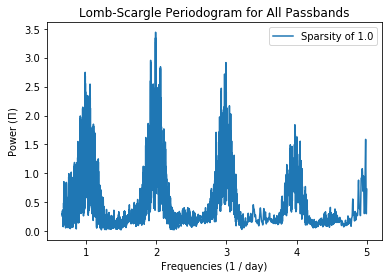

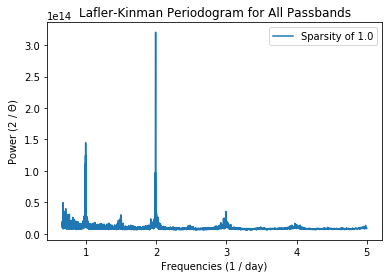

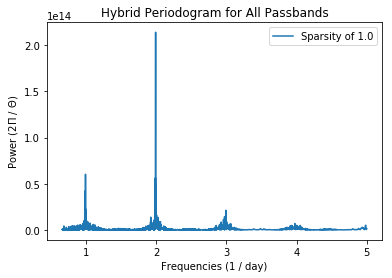

In [10]:
best_period = find_best_period()[2];

print("Best Period is", best_period, "Days")
print("True Period is", true_period, "Days")

In [11]:
def phase_light_curve(best_period, passband = 'g', sparsity = 1.0, seed = 0):
    """Phases the variable star light curve based on the best period.
    Then, plots the phased light curve in the specified passband."""
    
    times, magnitudes, magnitude_errors = filter_data(passband = passband, sparsity = sparsity, seed = seed)
    phases = (times / best_period) % 1
    
    plt.figure(figsize = (8, 5))
    plt.title(f'Phased Light Curve for RR Lyrae Star B1-392 ({passband} Passband)')
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.scatter(phases, magnitudes, label = f'Sparsity of {sparsity}')
    plt.errorbar(phases, magnitudes, yerr = magnitude_errors, linestyle = 'None')
    plt.legend(loc = 'lower right');
    
    return phases

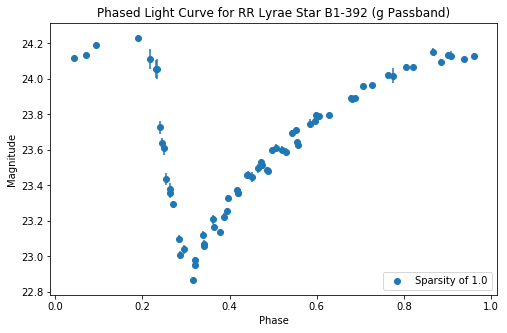

In [12]:
phases = phase_light_curve(best_period)

# Application to Hubble Space Telescope Data

In [13]:
path = 'J_ApJ_850_137'
photometry_data = glob.glob(os.path.join(path, 'b2*.dat'))

hubble_names_1 = ['Galaxy', 'Star', 'HJD-2400000.0 (F475W)', 'Magnitude (F475W)', 'Uncertainty in Magnitude (F475W)',
                 'HJD-2400000.0 (F814W)', 'Magnitude (F814W)', 'Uncertainty in Magnitude (F814W)']

hubble_photometry = pd.concat((pd.read_csv(file, sep = '\s{1,}', header = None, names = hubble_names_1, engine = 'python') 
                               for file in photometry_data)).sort_values(by = ['Galaxy', 'Star']).dropna()

hubble_photometry['Star'] = hubble_photometry['Star'].str.replace('-', '')
hubble_photometry.head()

,Galaxy,Star,HJD-2400000.0 (F475W),Magnitude (F475W),Uncertainty in Magnitude (F475W),HJD-2400000.0 (F814W),Magnitude (F814W),Uncertainty in Magnitude (F814W)
0,AndI,V001,57266.425781,25.254,0.089,57266.441406,24.713,0.090
1,AndI,V001,57266.500000,25.523,0.056,57266.484375,24.417,0.119
2,AndI,V001,57266.691406,25.801,0.041,57266.707031,24.953,0.067
3,AndI,V001,57266.765625,25.917,0.064,57266.750000,25.028,0.093
4,AndI,V001,57267.417969,25.175,0.036,57267.433594,24.364,0.043


In [14]:
pulsation_data = glob.glob(os.path.join(path, 'd4*.dat'))

hubble_names_2 = ['Galaxy', 'Star', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Hour)', 'Dec (Minutes)', 'Dec (Seconds)',
                 'Period (Days)', 'Magnitude (F475W)', 'Amplitude (F475W)', 'Magnitude (F814W)', 'Amplitude (F814W)',
                 'Magnitude (B-Band)', 'Amplitude (B-Band)', 'Magnitude (V-Band)', 'Amplitude (V-Band)', 'Magnitude (Ic-Band)',
                 'Amplitude (Ic-Band)', 'Variable Type', 'Camera']

hubble_pulsation = pd.concat((pd.read_csv(file, sep = '\s{1,}', header = None, names = hubble_names_2, engine = 'python') 
                              for file in pulsation_data)).sort_values(by = ['Galaxy', 'Star'])

hubble_pulsation['Star'] = hubble_pulsation['Star'].str.replace('-', '')
hubble_pulsation.head()

,Galaxy,Star,RA (Hour),RA (Minutes),RA (Seconds),Dec (Hour),Dec (Minutes),Dec (Seconds),Period (Days),Magnitude (F475W),...,Magnitude (F814W),Amplitude (F814W),Magnitude (B-Band),Amplitude (B-Band),Magnitude (V-Band),Amplitude (V-Band),Magnitude (Ic-Band),Amplitude (Ic-Band),Variable Type,Camera
0,AndI,V001,0,45,9.233,37,58,47.19,0.569,25.532,...,24.692,0.574,25.657,1.137,25.266,0.915,24.677,0.580,RRab,WFC3
1,AndI,V002,0,45,9.646,37,59,48.86,0.567,25.505,...,24.737,0.358,25.613,0.669,25.251,0.436,24.719,0.360,RRab,WFC3
2,AndI,V003,0,45,9.819,37,59,32.31,0.296,25.329,...,24.831,0.091,25.398,0.392,25.159,0.207,24.819,0.097,RRc,WFC3
3,AndI,V004,0,45,10.116,37,58,44.43,0.598,25.322,...,24.607,0.699,25.415,1.605,25.103,0.949,24.599,0.669,RRab,WFC3
4,AndI,V005,0,45,10.429,37,58,56.47,0.585,25.557,...,24.733,0.608,25.680,0.864,25.276,0.660,24.722,0.576,RRab,WFC3


In [15]:
def filter_hubble_data(galaxy = 'AndI', star = 'V001', passband = 'F475W', sparsity = 1.0, seed = 0):
    """Returns light curve data for a specific star in a specific band."""
    
    filtered = hubble_photometry[hubble_photometry['Galaxy'] == galaxy]
    filtered = filtered[filtered['Star'] == star]
    
    if passband == 'F475W':
        filtered = filtered.iloc[:, 2:5]
    else:
        filtered = filtered.iloc[:, 5:]
        
    if sparsity != 1.0:
        if seed == 0:
            filtered = filtered.sample(frac = sparsity)
        else:
            filtered = filtered.sample(frac = sparsity, random_state = seed)
        
    epoch = filtered.iloc[:, 0].values
    magnitudes = filtered.iloc[:, 1].values
    magnitude_errors = filtered.iloc[:, 2].values
    return epoch, magnitudes, magnitude_errors


def plot_hubble_periodogram(galaxy = 'AndI', star = 'V001', passband = 'F475W', sparsity = 1.0, seed = 0, plot = True):
    """Plots Lomb-Scargle, Lafler-Kinman, and hybrid periodograms for a variable star light curve."""
    
    epoch, magnitudes, magnitude_errors = filter_hubble_data(galaxy = galaxy, star = star, passband = passband, 
                                                             sparsity = sparsity, seed = seed)
    
    frequencies, ls_powers, lk_powers, hybrid_powers, best_period = hybrid_statistic(epoch, magnitudes, magnitude_errors)
    
    if plot:
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($\Pi$)')
        plt.title(f'Lomb-Scargle Periodogram for {passband} Passband \nfor Star {star} in Galaxy {galaxy}')
        plt.plot(frequencies, ls_powers, label = f"Sparsity of {sparsity}")
        plt.legend();
    
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2$ / $\Theta$)')
        plt.title(f'Lafler-Kinman Periodogram for {passband} Passband \nfor Star {star} in Galaxy {galaxy}')
        plt.plot(frequencies, lk_powers, label = f"Sparsity of {sparsity}")
        plt.legend();
    
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
        plt.title(f'Hybrid Periodogram for {passband} Passband for \nStar {star} in Galaxy {galaxy}')
        plt.plot(frequencies, hybrid_powers, label = f"Sparsity of {sparsity}")
        plt.legend();
    
    return [frequencies, ls_powers, lk_powers, hybrid_powers, best_period]

Finding optimal frequency:
 - Estimated peak width = 1.18
 - Using 5 steps per peak; omega_step = 0.237
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 117 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period in F475W Passband is 0.5637763776377638 Days


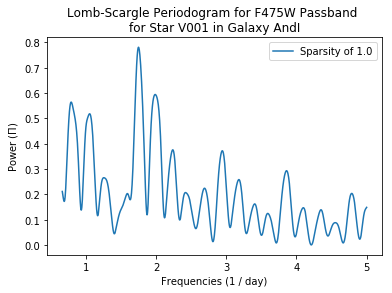

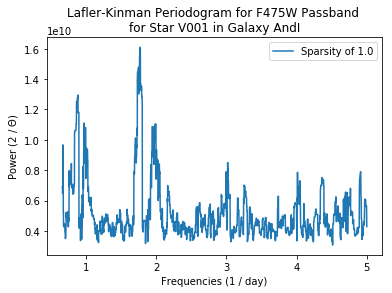

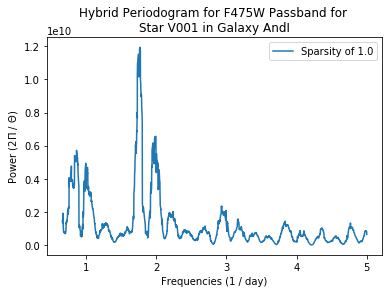

In [16]:
best_period_AndI_V001_F475W = plot_hubble_periodogram()[4];
print(f"\nBest Period in F475W Passband is {best_period_AndI_V001_F475W} Days")

In [17]:
def find_best_hubble_period(galaxy = 'AndI', star = 'V001', sparsity = 1.0, seed = 0, plot = True):
    """Find the best period by averaging across the results from both passbands."""
    
    freqs, ls_powers, lk_powers, hybrid_powers, period = plot_hubble_periodogram(galaxy = galaxy, star = star, 
                                                                                 passband = 'F475W', sparsity = sparsity, 
                                                                                 seed = seed, plot = False)
    
    new_results = plot_hubble_periodogram(galaxy = galaxy, star = star, passband = 'F814W', 
                                          sparsity = sparsity, seed = seed, plot = False)
    
    ls_powers = ls_powers + new_results[1]
    lk_powers = lk_powers + new_results[2]
    hybrid_powers = hybrid_powers + new_results[3]
        
    if plot:
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($\Pi$)')
        plt.title(f'Lomb-Scargle Periodogram for Both Passbands for \nStar {star} in Galaxy {galaxy}')
        plt.plot(freqs, ls_powers, label = f'Sparsity of {sparsity}')
        plt.legend();
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2$ / $\Theta$)')
        plt.title(f'Lafler-Kinman Periodogram for Both Passbands for \nStar {star} in Galaxy {galaxy}')
        plt.plot(freqs, lk_powers, label = f'Sparsity of {sparsity}')
        plt.legend();
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
        plt.title(f'Hybrid Periodogram for Both Passbands for \nStar {star} in Galaxy {galaxy}')
        plt.plot(freqs, hybrid_powers, label = f'Sparsity of {sparsity}');
        plt.legend();
        
    best_ls_period = 1 / (freqs[np.argmax(ls_powers)])
    best_lk_period = 1 / (freqs[np.argmax(lk_powers)])
    best_hybrid_period = 1 / (freqs[np.argmax(hybrid_powers)])
    
    return [best_ls_period, best_lk_period, best_hybrid_period]

Finding optimal frequency:
 - Estimated peak width = 1.18
 - Using 5 steps per peak; omega_step = 0.237
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 117 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 1.19
 - Using 5 steps per peak; omega_step = 0.238
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 116 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period is 0.5676767676767677 Days


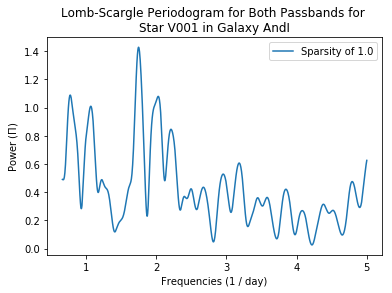

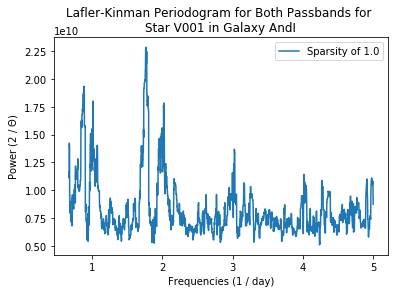

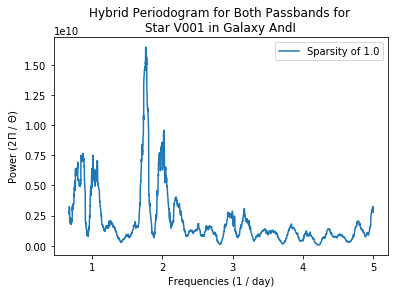

In [18]:
best_period_AndI_V001 = find_best_hubble_period()[2];
print(f"\nBest Period is {best_period_AndI_V001} Days")

In [19]:
computed_periods = hubble_pulsation[['Galaxy', 'Star', 'Period (Days)']]
computed_periods.info()
computed_periods.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 89
Data columns (total 3 columns):
Galaxy           895 non-null object
Star             895 non-null object
Period (Days)    895 non-null float64
dtypes: float64(1), object(2)
memory usage: 28.0+ KB


,Galaxy,Star,Period (Days)
0,AndI,V001,0.569
1,AndI,V002,0.567
2,AndI,V003,0.296
3,AndI,V004,0.598
4,AndI,V005,0.585


In [30]:
# hubble_periods = []
# for index, row in computed_periods.iterrows():
#     new_period = find_best_hubble_period(galaxy = row['Galaxy'], star = row['Star'], plot = False)[2]
#     hubble_periods.append(new_period)
# hubble_periods = np.array(hubble_periods)
# pickle.dump(hubble_periods, open("hubble_periods.pkl", "wb"))

hubble_periods = pickle.load(open("hubble_periods.pkl", "rb"))
computed_periods['Best Period (Days)'] = hubble_periods
computed_periods.head()

,Galaxy,Star,Period (Days),Best Period (Days)
0,AndI,V001,0.569,0.567677
1,AndI,V002,0.567,0.569237
2,AndI,V003,0.296,0.293479
3,AndI,V004,0.598,0.598360
4,AndI,V005,0.585,0.576128


In [31]:
np.average(np.abs(computed_periods.iloc[:, 3] - computed_periods.iloc[:, 2]))

0.024644598649809116

In [32]:
def phase_hubble_light_curve(best_period, galaxy = 'AndI', star = 'V001', passband = 'F475W', sparsity = 1.0, seed = 0):
    """Phases the variable star light curve based on the best period.
    Then, plots the phased light curve in the specified passband."""
    
    times, magnitudes, magnitude_errors = filter_hubble_data(galaxy = galaxy, star = star, passband = passband, 
                                                             sparsity = sparsity, seed = seed)
    phases = (times / best_period) % 1
    
    plt.figure(figsize = (8, 5))
    plt.title(f'Phased Light Curve for RR Lyrae Star {star} \nin Galaxy {galaxy} ({passband} Passband)')
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.scatter(phases, magnitudes, label = f'Sparsity of {sparsity}')
    plt.errorbar(phases, magnitudes, yerr = magnitude_errors, linestyle = 'None')
    plt.legend(loc = 'lower right');
    
    return phases

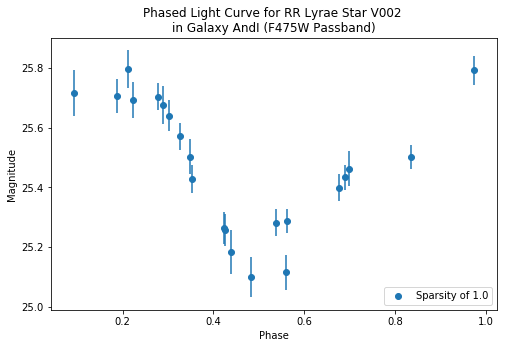

In [33]:
AndI_V001_phases = phase_hubble_light_curve(computed_periods.iloc[1, 3], galaxy = 'AndI', star = 'V002')

# Investigating the Effects of Sparsity

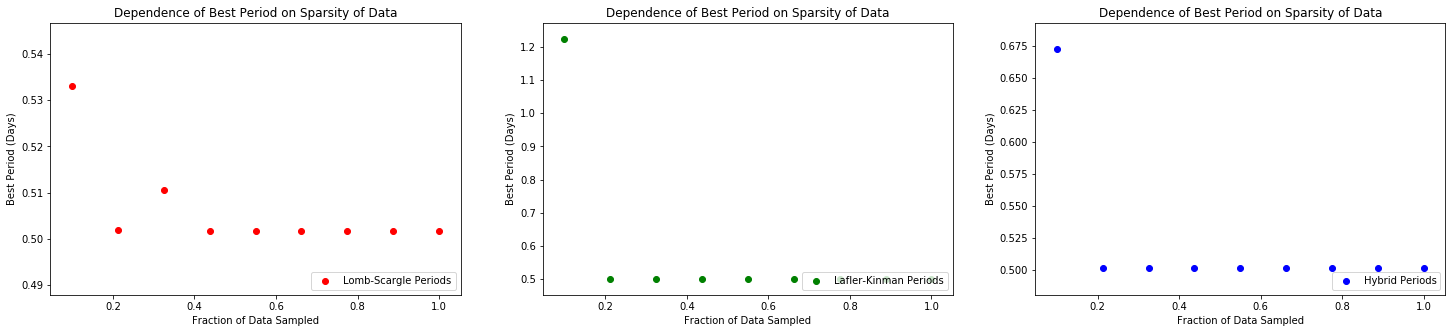

In [34]:
fractions = np.linspace(0.1, 1.0, 9)

# sparse_periods = np.array([find_best_period(sparsity = fraction, plot = False) for fraction in fractions])
# pickle.dump(sparse_periods, open("sparse_periods.pkl", "wb"))

sparse_periods = pickle.load(open("sparse_periods.pkl", "rb"))
sparse_ls_periods = sparse_periods[:, 0]
sparse_lk_periods = sparse_periods[:, 1]
sparse_hybrid_periods = sparse_periods[:, 2]

fig, axs = plt.subplots(1, 3, figsize = (25, 5))
for ax in axs:
    ax.set_title('Dependence of Best Period on Sparsity of Data')
    ax.set_xlabel('Fraction of Data Sampled')
    ax.set_ylabel('Best Period (Days)')
axs[0].scatter(fractions, sparse_ls_periods, label = 'Lomb-Scargle Periods', color = 'r')
axs[1].scatter(fractions, sparse_lk_periods, label = 'Lafler-Kinman Periods', color = 'g')
axs[2].scatter(fractions, sparse_hybrid_periods, label = 'Hybrid Periods', color = 'b')
for ax in axs:
    ax.legend(loc = 'lower right');

Finding optimal frequency:
 - Estimated peak width = 0.00908
 - Using 5 steps per peak; omega_step = 0.00182
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14998 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00907
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15016 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15021 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - C

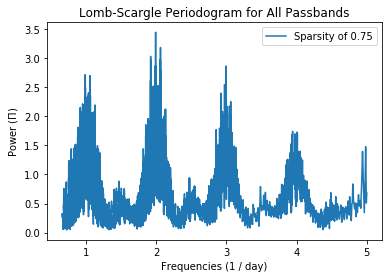

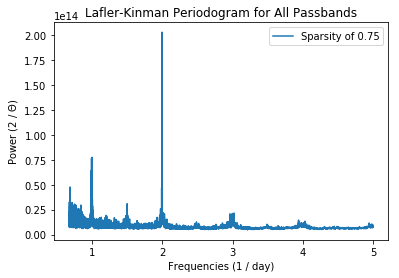

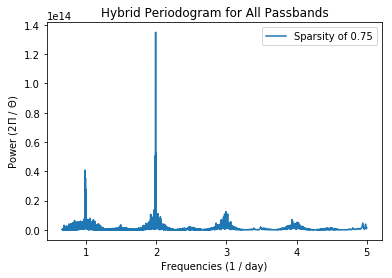

In [25]:
results_0_75 = find_best_period(sparsity = 0.75, seed = 1, plot = True)

Finding optimal frequency:
 - Estimated peak width = 0.00908
 - Using 5 steps per peak; omega_step = 0.00182
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14998 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00907
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15016 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15021 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - C

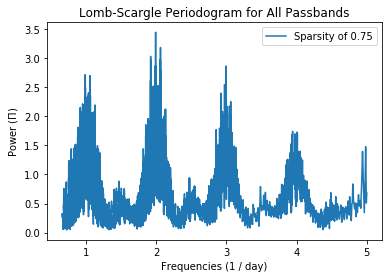

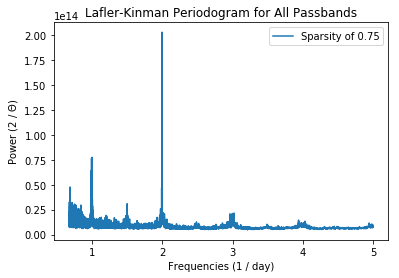

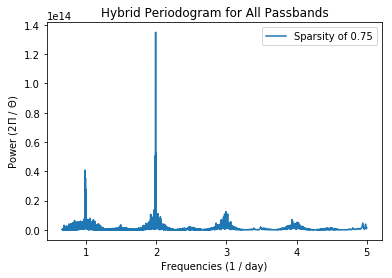

In [26]:
results_0_5 = find_best_period(sparsity = 0.75, seed = 1, plot = True)

Finding optimal frequency:
 - Estimated peak width = 0.00908
 - Using 5 steps per peak; omega_step = 0.00182
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14998 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00907
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15014 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00907
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15016 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00907
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15016 steps
Zooming-in on 5 candidate peaks:
 - 

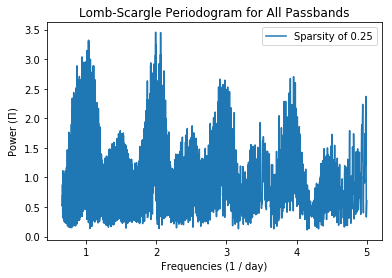

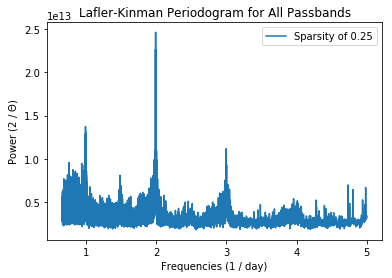

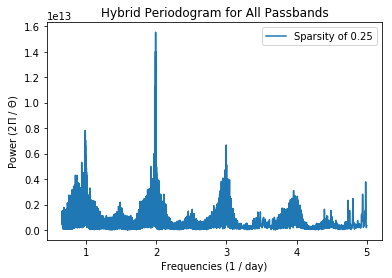

In [27]:
results_0_25 = find_best_period(sparsity = 0.25, seed = 1, plot = True)

Finding optimal frequency:
 - Estimated peak width = 3.01
 - Using 5 steps per peak; omega_step = 0.601
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 47 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00908
 - Using 5 steps per peak; omega_step = 0.00182
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14995 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 13138 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00965
 - Using 5 steps per peak; omega_step = 0.00193
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14111 steps
Zooming-in on 5 candidate peaks:
 - Computing

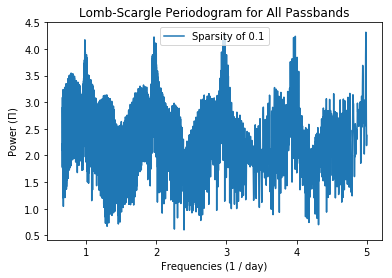

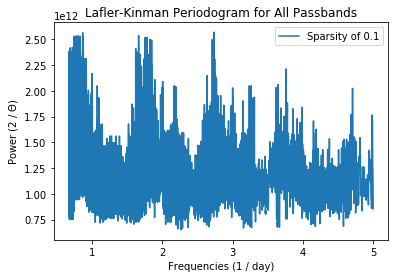

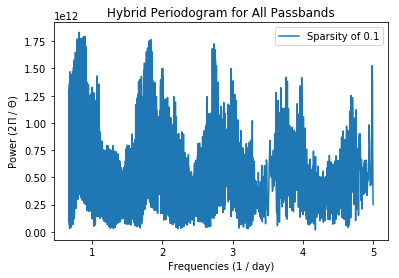

In [28]:
results_0_1 = find_best_period(sparsity = 0.1, seed = 1, plot = True)

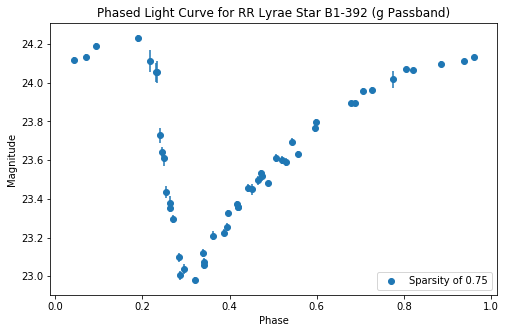

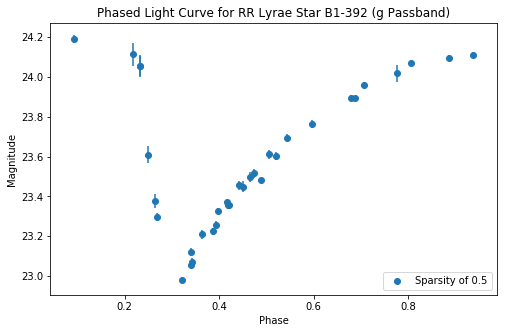

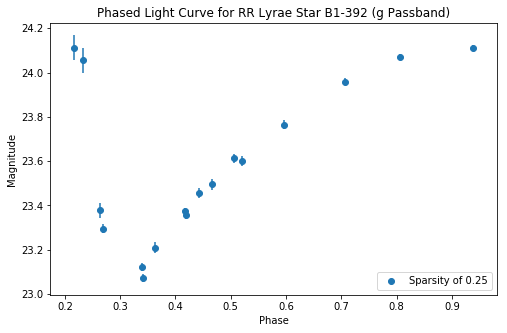

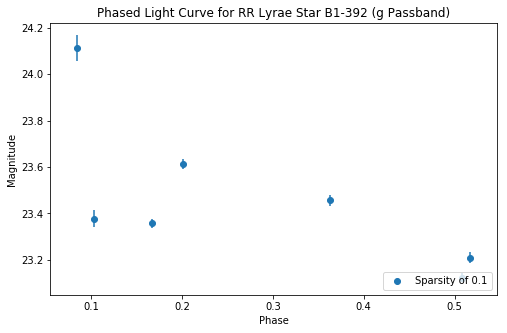

In [29]:
phases_0_75 = phase_light_curve(results_0_75[2], sparsity = 0.75, seed = 1)
phases_0_5 = phase_light_curve(results_0_5[2], sparsity = 0.5, seed = 1)
phases_0_25 = phase_light_curve(results_0_25[2], sparsity = 0.25, seed = 1)
phases_0_01 = phase_light_curve(results_0_1[2], sparsity = 0.10, seed = 1)